In [69]:
#Load the required libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [70]:
# Extract and read data from csv.zip
ads_data = pd.read_csv('C:/Users/Ark/0_ANALYSIS/DA_projects/CTR_CPM/ads_data.csv.zip', compression='zip')

In [71]:
# Create a new column and change date format in it.
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

In [72]:
ads_data.dtypes

ad_id                             int64
time                              int64
event                            object
date                             object
ad_cost_type                     object
has_video                         int64
client_union_id                   int64
campaign_union_id                 int64
platform                         object
ad_cost                         float64
target_audience_count             int64
user_id                           int64
full_date                datetime64[ns]
dtype: object

In [73]:
# change date format for "date" column
ads_data.date = pd.to_datetime(ads_data.date)

In [74]:
ads_data.date.unique()

array(['2019-04-01T00:00:00.000000000', '2019-04-02T00:00:00.000000000',
       '2019-04-03T00:00:00.000000000', '2019-04-04T00:00:00.000000000',
       '2019-04-05T00:00:00.000000000', '2019-04-06T00:00:00.000000000'],
      dtype='datetime64[ns]')

<AxesSubplot:xlabel='date'>

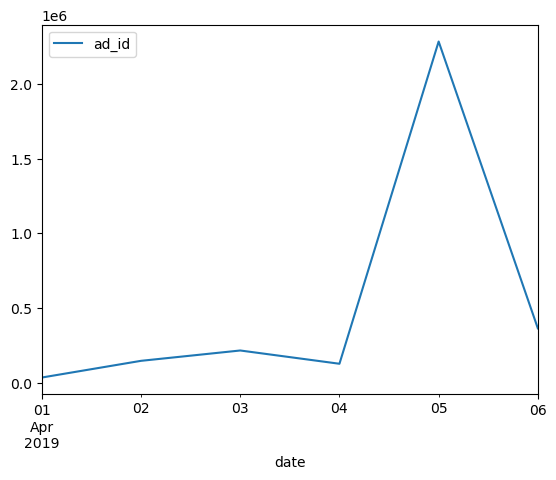

In [75]:
# statistics of these days
ads_data\
    .groupby("date")\
    .agg({"ad_id":"count"})\
    .plot()

In [76]:
# there is some observation on April 5th

In [77]:
# What event took place at that day.

# w/o as_index=False pivot won't work.
ads_data\
    .groupby(["date", "event"], as_index=False)\
    .agg({"ad_id":"count"})\
    .pivot(index="date", columns="event", values="ad_id").reset_index()

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [78]:
# was there an overreaction on this date?

In [79]:
wtd = "2019-04-05"

In [80]:
#have a look at the ids on this date
ads_data\
    .query("date == @wtd")\
    .groupby("ad_id")\
    .agg({"time":"count"})\
    .sort_values("time", ascending=False)\
    .head(20)

,time
ad_id,
112583,2166611
29927,27186
44635,8268
46583,7327
44956,5656
46932,5653
105953,4910
35498,4786
45791,3830


In [81]:
# There is a 10-times difference between 1 and 2 observations.

In [82]:
spec_id = 112583

In [83]:
df_112583 = ads_data.query("ad_id == @spec_id & date == @wtd")\
    .groupby(["event", "platform"])\
    .agg({"ad_cost":"sum", "campaign_union_id":"count"})\
    .rename(columns={"campaign_union_id":"num_of_ads"})\
    .sort_values("num_of_ads", ascending=False)\
    .reset_index()

df_112583

,event,platform,ad_cost,num_of_ads
0,view,android,166258523.6,833794
1,view,ios,99584547.4,499421
2,view,web,66437886.6,333189
3,click,android,49730160.6,249399
4,click,ios,30053767.4,150721
5,click,web,19957347.8,100087


<AxesSubplot:xlabel='event', ylabel='num_of_ads'>

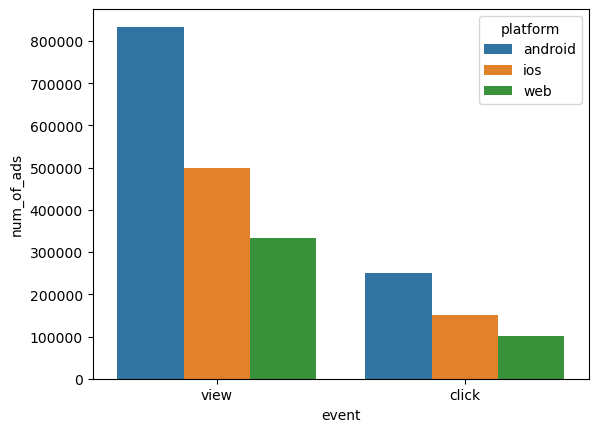

In [84]:
sns.barplot(data=df_112583, x="event", y="num_of_ads", hue="platform")

In [85]:
# Top 10 CTRs

In [86]:
ads_data_by_ad = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index()

In [87]:
ads_data_by_ad = ads_data_by_ad.assign(ctr = ads_data_by_ad.click / ads_data_by_ad.view, 
                           ctr_per = 100 * ads_data_by_ad.click / ads_data_by_ad.view)

In [88]:
ads_data_by_ad.sort_values('ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
289,112583,580436.0,1934788.0,0.300000,29.999979
324,119450,258.0,1254.0,0.205742,20.574163
125,38575,43.0,257.0,0.167315,16.731518
144,40968,29.0,217.0,0.133641,13.364055
207,45642,42.0,344.0,0.122093,12.209302
283,110924,11.0,95.0,0.115789,11.578947
194,45043,28.0,245.0,0.114286,11.428571
96,35034,112.0,997.0,0.112337,11.233701
5,4585,53.0,476.0,0.111345,11.134454
328,120347,236.0,2168.0,0.108856,10.885609


In [92]:
ads_data_by_ad.ctr.mean()

0.020628096080757965

In [93]:
ads_data_by_ad.ctr.median()

0.010753240746688594

In [ ]:
# 50% of observations below median

C:\Users\Ark\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

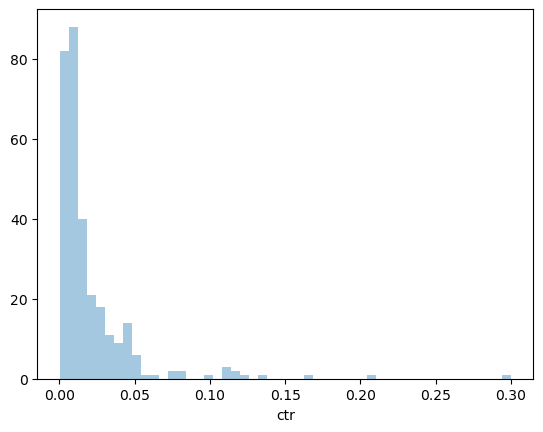

In [94]:
sns.distplot(ads_data_by_ad.ctr, kde=False)

In [95]:
# Median is almost 2 times less than mean
ads_data_by_ad.ctr.mean() / ads_data_by_ad.ctr.median()

1.918314354406162

In [96]:
# Suppose there is a bug in ads. Ads come with clicks but w/o views.

In [98]:
ads_data_by_ad.isna().sum()

event
ad_id       0
click      40
view        9
ctr        49
ctr_per    49
dtype: int64

In [99]:
ads_data_by_ad = ads_data_by_ad.fillna(0)

In [101]:
ads_data_by_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ad_id    355 non-null    int64  
 1   click    355 non-null    float64
 2   view     355 non-null    float64
 3   ctr      355 non-null    float64
 4   ctr_per  355 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 14.0 KB


In [102]:
ads_data_by_ad.head()

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,0.0,132.0,0.000000,0.000000
4,2643,3.0,286.0,0.010490,1.048951


In [105]:
ads_ids_bug = ads_data_by_ad.query('click == 0').ad_id
ads_ids_bug.head()

3      2475
26    16444
29    16678
30    16845
38    20871
Name: ad_id, dtype: int64

In [109]:
# ads with bugs
ads_w_bugs = ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

In [110]:
total_ads = ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .sort_values('ad_id')

In [115]:
# bugs share in ads
bugs_share = (ads_w_bugs.ad_id / total_ads.ad_id).sort_values(ascending=False)
# much the same
bugs_share

1    0.003226
2    0.003129
0    0.003089
Name: ad_id, dtype: float64

In [136]:
# first click then view
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'min'}) \
    .pivot(index='ad_id', columns='event', values='time').reset_index() \
    .query('click < view')

event,ad_id,click,view
27,16548,1.554336e+09,1.554336e+09
81,30939,1.554165e+09,1.554173e+09
138,40464,1.554164e+09,1.554164e+09
158,42007,1.554423e+09,1.554423e+09
185,44543,1.554336e+09,1.554337e+09
201,45436,1.554336e+09,1.554336e+09
324,119450,1.554336e+09,1.554336e+09


In [137]:
# ads with video more clickable?

# Consider data w/o specific ad_id = 112583

ads_data_video = ads_data\
    .query("ad_id != @spec_id")\
    .groupby(['has_video', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='has_video', columns='event', values='time').reset_index()

In [138]:
ads_data_video = ads_data_video.assign(ctr = ads_data_video.click / ads_data_video.view, 
                           ctr_per = 100 * ads_data_video.click / ads_data_video.view)

In [139]:
ads_data_video

event,has_video,click,view,ctr,ctr_per
0,0,7001,647325,0.010815,1.081528
1,1,26,7138,0.003642,0.364248
